# Homework 0 - Mercy's Game

## Quest to Bake a Special Cake!

By Mercy Raji

### Install required libraries

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


### Import Text Adventures

In [2]:
from text_adventure_games import (
    games, parsing, actions, things, blocks, viz
)

## Locations

In [3]:

home = things.Location(
    "Home",
    "You are at home."
)

syrus_forest = things.Location(
    "Syrus Forest",
    "You are in Syrus Forest, filled lush and beautiful trees."
)


arona_center = things.Location(
    "Arona Center",
    "You are in Arona Center, a bustling market place where you can find anything you need."
)

vera_river = things.Location(
    "Vera River",
    "You are at Vera River, where you can find beautiful Dugen berries."
)

death = things.Location(
    "The Afterlife",
    "You are dead. GAME OVER."
)


# Map of Locations
home.add_connection("north", arona_center)
home.add_connection("east", vera_river)

arona_center.add_connection("south", home)
arona_center.add_connection("east", syrus_forest)

syrus_forest.add_connection("west", arona_center)
syrus_forest.add_connection("south", vera_river)

vera_river.add_connection("north", syrus_forest)
vera_river.add_connection("west", home)




###  Preliminary Game Map

Here is a visualization of the locations in action castle represented as a directed graph.

![Visualization of game map starting from the tower](../map-from-tower.svg)

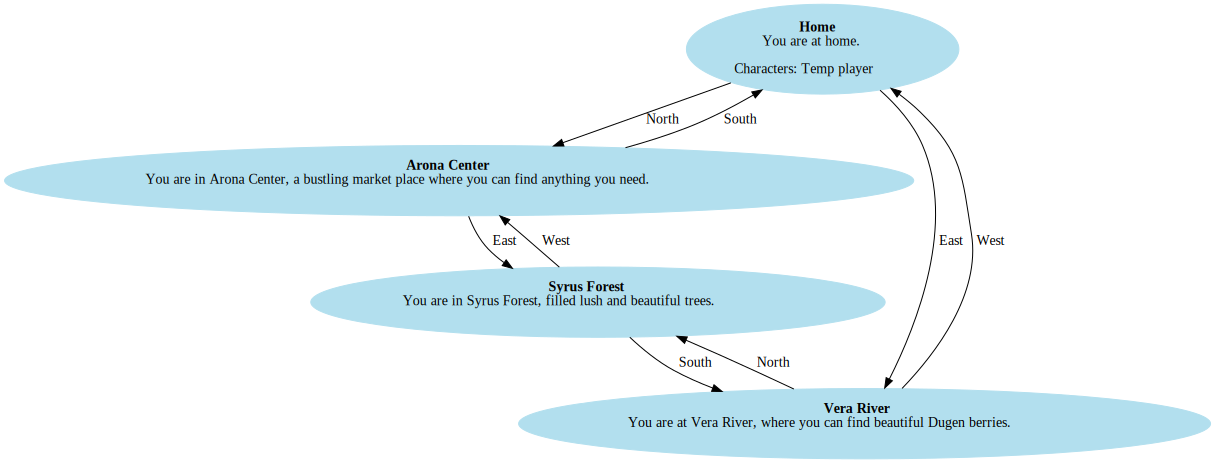

In [4]:
tempgame = games.Game(home, things.Character(name="Temp Player", description="", persona=""))

from text_adventure_games.viz import Visualizer
viz = Visualizer(tempgame)
graph = viz.visualize()
graph

## Items

### Gettable Items

In [5]:

# Add Dugen berries at Vera River
dugen_berries = things.Item(
    "dugen berries",
    "a handful of dugen berries",
    "A HANDFUL OF DUGEN BERRIES.",
)
vera_river.add_item(dugen_berries)

# Put a branch in a tree that could be used as a weapon
branch = things.Item(
    "branch",
    "a branch that looks like it's about to break apart",
    "IT LOOKS LIKE IT WOULD MAKE A GOOD WEAPON.",
)
branch.set_property("is_weapon", True)
branch.set_property("is_fragile", True)
syrus_forest.add_item(branch)



### Scenery Items

_We called these "non-gettable" in the tutorial_

In [6]:
# Add oven to house
oven = things.Item(
    "oven",
    "an oven",
    "AN OVEN.",
)
oven.set_property("gettable", False)
oven.add_command_hint("bake cake")
home.add_item(oven)


# Put tree in Syrus Forest
tree = things.Item(
    "tree",
    "a tree",
    "A TREE.",
)
tree.set_property("gettable", False)
tree.set_property("has_branch", True)
tree.add_command_hint("get branch")
syrus_forest.add_item(tree)

# Put river in Vera River
river = things.Item(
    "river",
    "a river",
    "A RIVER.",
)
river.set_property("gettable", False)
river.set_property("has_fish", True)
vera_river.add_item(river)

# Add dugen berry bush in Vera River
dugen_berry_bush = things.Item(
    "dugen berry bush",
    "a dugen berry bush",
    "A DUGEN BERRY BUSH.",
)
dugen_berry_bush.set_property("gettable", False)
dugen_berry_bush.set_property("has_dugen_berries", True)
dugen_berry_bush.add_command_hint("grab dugen berries")
vera_river.add_item(dugen_berry_bush)

# Add a merchant stall to Arona Center
merchant_stall = things.Item(
    "merchant stall",
    "a merchant stall",
    "A MERCHANT STALL.",
)
merchant_stall.set_property("gettable", False)
merchant_stall.set_property("has_spices", True)
merchant_stall.add_command_hint("buy spices")
arona_center.add_item(merchant_stall)




## Characters

### Player

In [7]:
# Player
player = things.Character(
    name="Player",
    description="You are a baker.",
    persona="I am on a quest to bake a special cake.",
)

money_pouch = things.Item("money pouch", "a money pouch", "A MONEY POUCH.")


player.add_to_inventory(money_pouch)
player.set_property("has_money", True)
player.set_property("baked_cake", False)
player.set_property("is_dead", False)


### Non-Player Characters (NPCs)

In [8]:
# A snake that guards the dugen berry bush
snake = things.Character(
    name="snake",
    description="A snake",
    persona="I am a venomous snake. I guard the dugen berry bush. I will bite anyone who tries to take the berries.",
)
snake.set_property("is_conscious", True)
snake.set_property("is_venomous", True)
snake.set_property("character_type", "snake")
vera_river.add_character(snake)

# a merchant from Kimen that has well sought after Kimen Mountain spices
merchant = things.Character(
    name="merchant",
    description="A Kimeni merchant",
    persona="I am a merchant from Kimen. I have well sought after Kimen Mountain spices.",
)

kimeni_spices = things.Item(
    "kimeni spices",
    "a bag of kimeni spices",
    "A BAG OF KIMENI SPICES.",
)
merchant.add_to_inventory(kimeni_spices)
merchant.set_property("has_spices", True)
merchant.set_property("is_conscious", True)
merchant.set_property("character_type", "human")
arona_center.add_character(merchant)





## Actions

In [9]:
class Bake_Cake(actions.Action):
    ACTION_NAME = "bake cake"
    ACTION_DESCRIPTION = "Bake a special cake using the special ingredients you found"
    ACTION_ALIASES = ["make cake"]
    
    def __init__(self, game, command):
        super().__init__(game)
        
        self.character: things.Character = game.player
        self.location = self.character.location
        self.oven = self.location.items.get("oven") # if they are actually home
        
        self.dugen_berries: things.Item = game.parser.match_item("dugen berries", self.parser.get_items_in_scope(self.character))
        self.kimeni_spices: things.Item = game.parser.match_item("kimeni spices", self.parser.get_items_in_scope(self.character))

        

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * Player must be at home (which will have the oven)
        * Player must have all special ingredients
        """
        is_home = self.was_matched(self.location, "There's no home here")
        if (self.dugen_berries is not None) & (self.kimeni_spices is not None):
            has_ingredients = True
        else:
            has_ingredients = False
        
        if (is_home & has_ingredients) == False:
            self.parser.fail("You can't bake the special cake.")
            return False
        else:
            return True
        


    def apply_effects(self):
        """
        Effects:
        * Special cake has been baked!
        """
        self.parser.ok("You baked a special cake!")
        self.character.set_property("baked_cake", True)

In [10]:
class Buy_Spices(actions.Action):
    """
    Buy Kimeni spices from Kimeni merchant
    """
    ACTION_NAME = "buy spices"
    ACTION_DESCRIPTION = "Player buys spices from merchant in Arona Center"
    ACTION_ALIASES = ["get spices"]

    def __init__(self, game, command):
        super().__init__(game)
        self.character: things.Character = game.player
        self.merchant: things.Character = game.characters.get("merchant")
        

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * Player and merchant must be at the same place
        * Player must have money
        * Merchant must have spices
        """
        same_place = self.character.location == self.merchant.location
        if self.merchant.get_property("has_spices"):
            has_spices = True
        else:
            has_spices = False
        
        has_money = self.character.get_property("has_money")

        if (same_place & has_spices & has_money) == False:
            self.parser.fail("You can't buy the spices.")
            return False
        else:
            return True

    def apply_effects(self):
        """
        Effects:
        * Merchant gives spices to player
        * Player's money pouch is empty
        """

        kimeni_spices = things.Item(
            "kimeni spices",
            "a bag of kimeni spices",
            "A BAG OF KIMENI SPICES.",
        )
        
        self.merchant.remove_from_inventory(kimeni_spices)
        self.merchant.set_property("has_spices", False)

        self.character.add_to_inventory(kimeni_spices)
        self.character.set_property("has_money", False)
        
        self.parser.ok("You bought the kimeni spices!")
        self.parser.ok("You have no more money.")


In [11]:
class Hit_Snake(actions.Action):
    """
    Hit the venomous snake!
    """
    ACTION_NAME = "kill snake"
    ACTION_DESCRIPTION = "Hit the venomous snake"
    ACTION_ALIASES = []


    def __init__(self, game, command):
        super().__init__(game)
        
        self.character: things.Character = game.player
        self.snake: things.Character = game.characters.get("snake")
        self.branch: things.Item = game.parser.match_item("branch", self.parser.get_items_in_scope(self.character))

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * Snake and player must be in the same place
        * Snake must be conscious
        * Player must have a branch
        """
        same_place = self.character.location == self.snake.location
        is_conscious = self.snake.get_property("is_conscious")
        has_branch = self.branch is not None
    
        # this block of code checks preconditions and applies death effect if met
        if (same_place & is_conscious & (not has_branch)):
            self.parser.fail("You can't hit the snake.")
            self.parser.ok("The snake bites you and you die. Game over")
            self.character.location = death
            self.character.set_property("is_dead", True)
            return False
        
        elif (same_place & is_conscious & has_branch) == False:
            self.parser.fail("You can't hit the snake.")
            return False
        else:
            return True
        

    def apply_effects(self):
        """
        Effects:
        * If snake is hit, it will die and player can grab dugen berries
        """
        self.parser.ok("You hit the snake and it dies.")
        self.snake.set_property("is_conscious", False)

In [12]:
class Grab_Dugen_Berries(actions.Action):
    """
    Grab the dugen berries!
    """
    ACTION_NAME = "grab dugen berries"
    ACTION_DESCRIPTION = "Grab the dugen berries"
    ACTION_ALIASES = ["pick dugen berries"]
    
    def __init__(self, game, command):
        super().__init__(game)
        self.character: things.Character = game.player
        self.dugen_berry_bush = self.parser.match_item("dugen berry bush", self.parser.get_items_in_scope(self.character))
        self.snake: things.Character = game.characters.get("snake")
        self.dugen_berries: things.Item = game.parser.match_item("dugen berries", self.parser.get_items_in_scope(self.character))

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * Character must be in the same location as dugen berry bush
        * Snake is not guarding dugen berry bush
        * The dugen berry bush has dugen berries
        """
        same_place = self.character.location == self.dugen_berry_bush.location
        snake_not_guarding = not self.snake.get_property("is_conscious")
        has_dugen_berries = self.dugen_berry_bush.get_property("has_dugen_berries")
        
        if (same_place & snake_not_guarding & has_dugen_berries) == False:
            self.parser.fail("You can't grab the dugen berries.")
            return False
        else:
            return True


    def apply_effects(self):
        """
        The player now has dugen berries!
        """
        self.parser.ok("You grabbed the dugen berries!")
        self.character.add_to_inventory(self.dugen_berries)
        self.dugen_berry_bush.set_property("has_dugen_berries", False)



## Blocks


In [13]:
# Snake block

class Snake_Block(blocks.Block):
    """
    Blocks progress in Vera River until the snake is no longer conscious
    """

    def __init__(self, location: things.Location, snake: things.Character):
        super().__init__(
            "A venomous snake blocks your way", "A venomous snake blocks you from going"
        )
        self.location = location
        self.snake = snake

    def is_blocked(self) -> bool:
        # Conditions of block:
        # * There is a snake here
        # * The snake is alive and conscious
        if self.snake:
            if self.location.here(self.snake) & self.snake.get_property("is_conscious"):
                return True
        return False


In [14]:

# * Vera River - the snake prevents you from going to Syrus Forest
snake_block = Snake_Block(vera_river, snake)
vera_river.add_block("north", snake_block)


## Play Baking Quest

In [15]:
class BakingQuest(games.Game):
    def __init__(
        self, start_at: things.Location, player: things.Character, characters=None,
        custom_actions=None
    ):
        super().__init__(start_at, player, characters=characters, custom_actions=custom_actions)

    def is_won(self) -> bool:
        """ 
        Checks whether the game has been won. For Action Castle, the game is won
        once any character is sitting on the throne (has the property is_reigning).
        """
        for name, character in self.characters.items():
            if character.get_property("baked_cake"):
                msg = "{name} baked a delicious cake with Kimeni Spices and Dugen Berries! {name} has won the game!"
                self.parser.ok(msg.format(name=character.name.title()))
                return True
        return False

    def has_lost(self) -> bool:
        """
        Checks whether game is over. Game is over if the player has died.
        """
        for name, character in self.characters.items():
            if character.get_property("is_dead"):
                msg = "{name} has died. {name} has lost the game!"
                self.parser.ok(msg.format(name=character.name.title()))
                return True
        return False

In [16]:

characters = [snake, merchant]
custom_actions = [Bake_Cake, Buy_Spices, Hit_Snake, Grab_Dugen_Berries]

# The Game
game = BakingQuest(home, player, characters=characters, custom_actions=custom_actions)


In [17]:
# The error suggests that there is an attempt to access the 'owner' attribute of a NoneType object.
# This likely occurs when trying to access an item that doesn't exist in the inventory.
# Let's add some debugging prints to identify where the NoneType is coming from.

class Buy_Spices(actions.Action):
    """
    Buy Kimeni spices from Kimeni merchant
    """
    ACTION_NAME = "buy spices"
    ACTION_DESCRIPTION = "Player buys spices from merchant in Arona Center"
    ACTION_ALIASES = ["get spices"]

    def __init__(self, game, command):
        super().__init__(game)
        self.character: things.Character = game.player
        self.merchant: things.Character = game.characters.get("merchant")
        

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * Player and merchant must be at the same place
        * Player must have money
        * Merchant must have spices
        """
        same_place = self.character.location == self.merchant.location
        if self.merchant.get_property("has_spices"):
            has_spices = True
        else:
            has_spices = False
        
        has_money = self.character.get_property("has_money")

        if (same_place & has_spices & has_money) == False:
            self.parser.fail("You can't buy the spices.")
            return False
        else:
            return True

    def apply_effects(self):
        """
        Effects:
        * Merchant gives spices to player
        * Player's money pouch is empty
        """

        kimeni_spices = things.Item(
            "kimeni spices",
            "a bag of kimeni spices",
            "A BAG OF KIMENI SPICES.",
        )

        print("Merchant type: ", self.merchant)
        print("Merchant inventory: ", self.merchant.inventory)
        
        # Debugging print to check if the item exists in the inventory
        print("Spices in merchant inventory: ", self.merchant.inventory.get("kimeni_spices"))
        
        # Fix: Check if the item exists before trying to remove it
        spices_item = self.merchant.inventory.get("kimeni_spices")
        if spices_item:
            self.merchant.remove_from_inventory(spices_item)
            self.merchant.set_property("has_spices", False)

            self.character.add_to_inventory(kimeni_spices)
            self.character.set_property("has_money", False)
            
            self.parser.ok("You bought the kimeni spices!")
            self.parser.ok("You have no more money.")
        else:
            self.parser.fail("The merchant does not have any spices to sell.")

# Re-run the game loop to test the fix
game.game_loop()

You are at home.
Exits:
North to Arona Center
East to Vera River

You see:
 * an oven
        bake cake
Characters:
 *

You are at Vera River, where you can find beautiful Dugen berries.
Exits:
West to Home
North to Syrus Forest

You see:
 * a handful of dugen berries
 * a river
 * a dugen berry bush
        grab dugen berries
Characters:
 * A snake

You can't hit the snake.
The snake bites you and you die. Game over


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c53bb044-3953-42b6-83c3-748d614c1905' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>